**Cardiovascular Disease (сердечно-сосудистые заболевания)** — публичный набор данных (~70 000 наблюдений), цель — бинарная переменная cardio (1 — есть заболевание, 0 — нет). Каждая строка — один пациент/осмотр.

https://www.kaggle.com/datasets/sulianova/cardiovascular-disease-dataset

**Основные признаки**:

*   **age** — возраст в днях;
*   **gender** — пол (1 — женщина, 2 — мужчина);
*   **height** — рост, см;
*   **weight** — масса, кг;
*   **ap_hi** — систолическое артериальное давление, мм рт. ст.;
*   **ap_lo** — диастолическое артериальное давление, мм рт. ст.;
*   **cholesterol** — уровень холестерина (категориально: 1 — норма, 2 — выше нормы, 3 — значительно выше);
*   **gluc** — уровень глюкозы (1 — норма, 2 — выше нормы, 3 — значительно выше);
*   **smoke** — курение (0/1);
*   **alco** — употребление алкоголя (0/1);
*   **active** — физическая активность (0/1).

# Этап 0. Установка пакетов и импорт датасета

In [ ]:
!pip -q install kagglehub==0.2.5 xgboost lightgbm catboost scikit-learn matplotlib seaborn pandas numpy imbalanced-learn
!pip -q install -U "kagglehub[pandas-datasets]"

import warnings, os, pathlib
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, confusion_matrix, RocCurveDisplay)

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.3/68.3 kB 6.4 MB/s eta 0:00:00


In [ ]:
!pip install kagglehub

In [ ]:
import kagglehub
from kagglehub import KaggleDatasetAdapter

#загрузка датасета "Cardiovascular Disease" из Kaggle с помощью kagglehub
df_raw = kagglehub.dataset_load(
    KaggleDatasetAdapter.PANDAS,
    "sulianova/cardiovascular-disease-dataset",
    "cardio_train.csv",
    pandas_kwargs={"sep": ";"} #указание разделителя столбцов
)

df = df_raw.copy() #рабочая копия датасета для дальнейших преобразований

print("Shape:", df.shape)
df.head(5)

Using Colab cache for faster access to the 'cardiovascular-disease-dataset' dataset.
Shape: (70000, 13)


,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


Программная среда подготовлена: установлены и импортированы необходимые библиотеки анализа данных и машинного обучения.

Зафиксирован параметр случайности RANDOM_STATE = 42 для воспроизводимости экспериментов.

Датасет Cardiovascular Disease успешно загружен из Kaggle (70 000 строк и 13 столбцов).

Таблица df готова для проведения разведочного анализа данных (EDA) и последующей предобработки.

# Этап 1. Разведочный анализ данных (EDA), Feature Engineering, визуализации и подготовка признаков для моделей

In [ ]:
TARGET_COL = "cardio" #таргетная переменная
assert TARGET_COL in df.columns, f"Целевая колонка '{TARGET_COL}' не найдена. Колонки: {df.columns.tolist()}"

#идентификатор "id" удаляем, не несет предсказательной ценности
drop_candidates = [c for c in ["id"] if c in df.columns]
df.drop(columns=drop_candidates, inplace=True)

#диагностика типов, пропусков и структуры целевой переменной
print("\nТипы данных:")
print(df.dtypes)
print("\nПропуски по колонкам:")
print(df.isna().sum().sort_values(ascending=False))

print("\nБаланс классов (cardio):")
print(df[TARGET_COL].value_counts())
print("Доля класса 1:", df[TARGET_COL].mean().round(4))


Типы данных:
age              int64
gender           int64
height           int64
weight         float64
ap_hi            int64
ap_lo            int64
cholesterol      int64
gluc             int64
smoke            int64
alco             int64
active           int64
cardio           int64
dtype: object

Пропуски по колонкам:
age            0
gender         0
height         0
weight         0
ap_hi          0
ap_lo          0
cholesterol    0
gluc           0
smoke          0
alco           0
active         0
cardio         0
dtype: int64

Баланс классов (cardio):
cardio
0    35021
1    34979
Name: count, dtype: int64
Доля класса 1: 0.4997


In [ ]:
#Feature Engineering: доменно-осмысленные производные признаки
#возраст исходно дан в днях, переводим в года
if "age" in df.columns:
    df["age_years"] = (df["age"] / 365.25).astype(float)
else:
    raise ValueError("Нет колонки 'age' (ожидается возраст в днях).")

#индекс массы тела (BMI) добавляем — стандартный медицинский индикатор, значим для задач ССЗ
if set(["height","weight"]).issubset(df.columns):
    h_m = df["height"] / 100.0
    df["bmi"] = df["weight"] / (h_m ** 2)
else:
    raise ValueError("Ожидаются 'height' и 'weight' для расчёта BMI.")

#пульсовое давление как разность систолического и диастолического АД
if set(["ap_hi","ap_lo"]).issubset(df.columns):
    df["pulse_pressure"] = df["ap_hi"] - df["ap_lo"]
else:
    raise ValueError("Ожидаются 'ap_hi' и 'ap_lo' для pulse_pressure.")

#бинарный признак избыточной массы тела (порог ВОЗ ≥ 25)
df["overweight"] = (df["bmi"] >= 25).astype(int)

#мягкая очистка экстремальных значений
#клиппирование по квантилям 1% и 99% снижает влияние редких выбросов,
#сохраняя при этом основную структуру распределений.
def clip_by_quantiles(s, low=0.01, high=0.99):
    ql, qh = s.quantile([low, high])
    return s.clip(ql, qh)

num_clean_cols = ["height","weight","ap_hi","ap_lo","bmi","pulse_pressure","age_years"]
for c in num_clean_cols:
    if c in df.columns:
        df[c] = clip_by_quantiles(df[c].astype(float), 0.01, 0.99)

#удаление физиологически некорректных наблюдений: требование ap_hi >= ap_lo
df = df[df["ap_hi"] >= df["ap_lo"]].copy()

print("\nПосле инженерии и первичной очистки:")
print(df.shape)
display(df[[TARGET_COL,"age_years","height","weight","bmi","ap_hi","ap_lo","pulse_pressure","overweight"]].head())


После инженерии и первичной очистки:
(68933, 16)


,cardio,age_years,height,weight,bmi,ap_hi,ap_lo,pulse_pressure,overweight
0,0,50.357290,168.0,62.0,21.967120,110.0,80.0,30.0,0
1,1,55.381246,156.0,85.0,34.927679,140.0,90.0,50.0,1
2,1,51.627652,165.0,64.0,23.507805,130.0,70.0,60.0,0
3,1,48.249144,169.0,82.0,28.710479,150.0,100.0,50.0,1
4,0,47.841205,156.0,56.0,23.011177,100.0,60.0,40.0,0


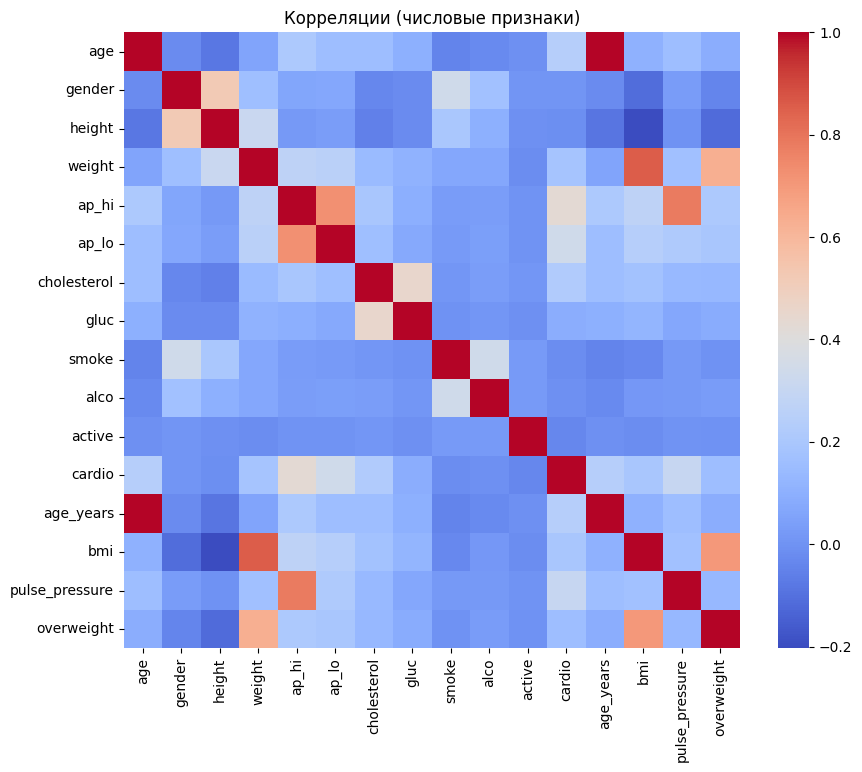

In [ ]:
#тепловая карта корреляций по числовым признакам
numeric_cols_auto = df.select_dtypes(include=[np.number]).columns.tolist()
plt.figure(figsize=(10,8))
sns.heatmap(df[numeric_cols_auto].corr(numeric_only=True), cmap="coolwarm", square=True, cbar=True)
plt.title("Корреляции (числовые признаки)")
plt.show()

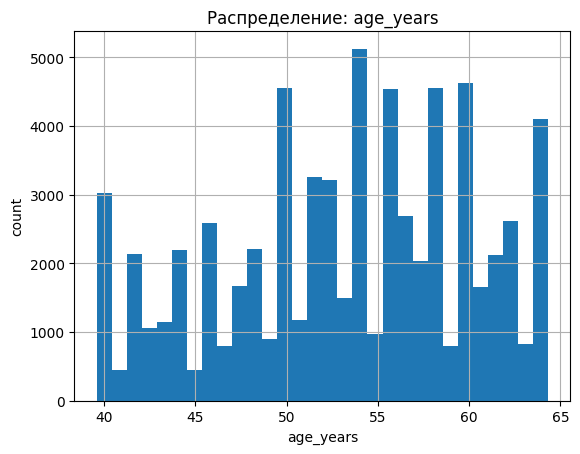

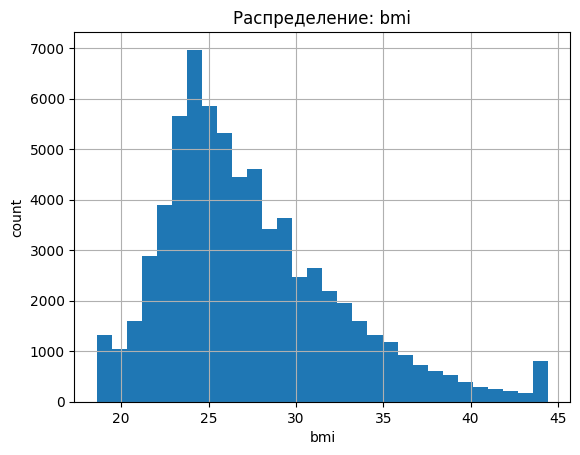

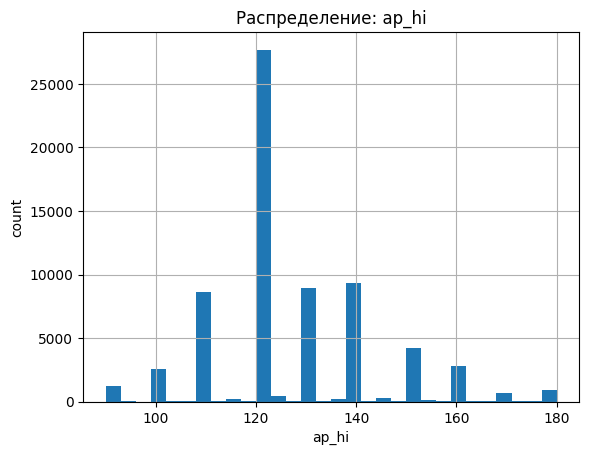

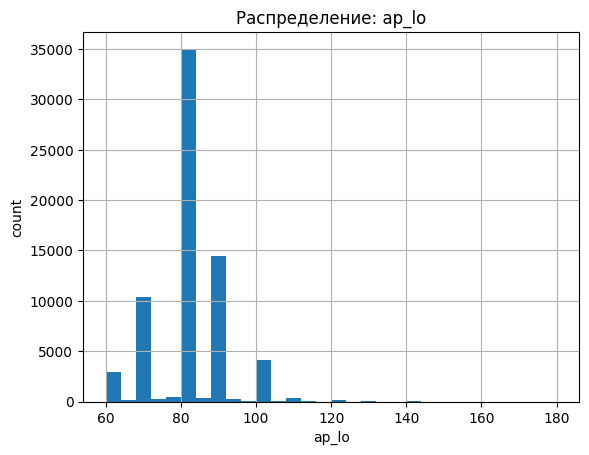

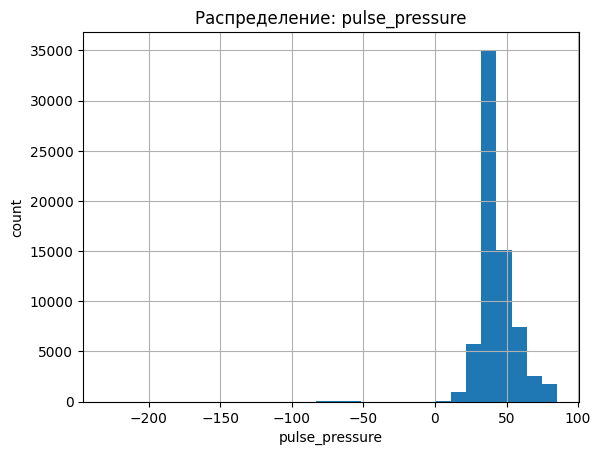

In [ ]:
#гистограммы ключевых числовых признаков
for col in ["age_years","bmi","ap_hi","ap_lo","pulse_pressure"]:
    if col in df.columns:
        plt.figure()
        df[col].hist(bins=30)
        plt.title(f"Распределение: {col}")
        plt.xlabel(col); plt.ylabel("count")
        plt.show()

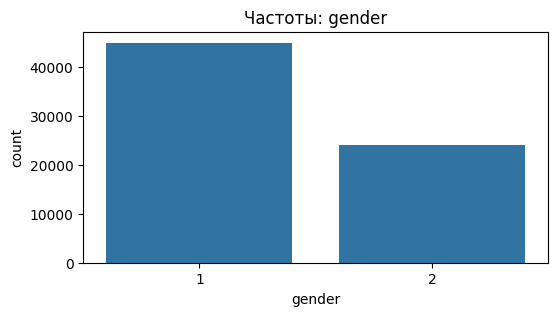

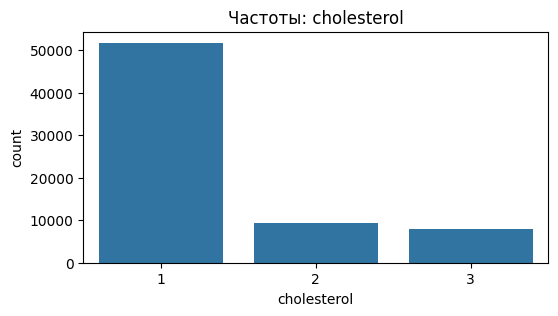

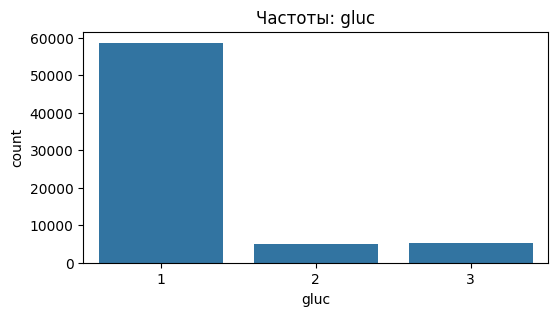

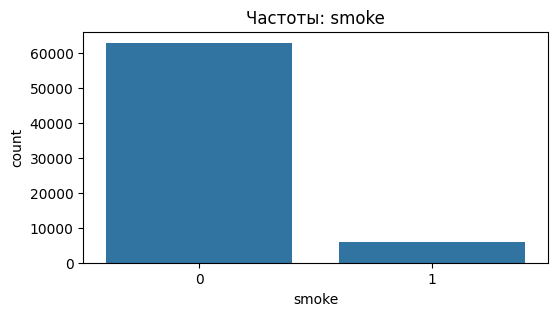

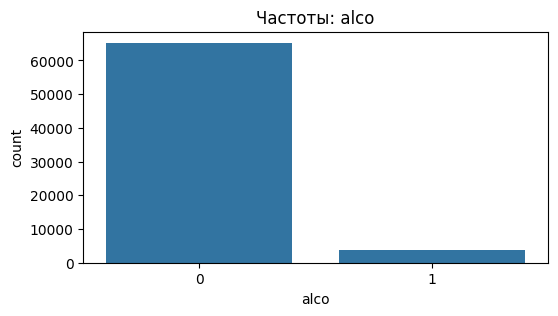

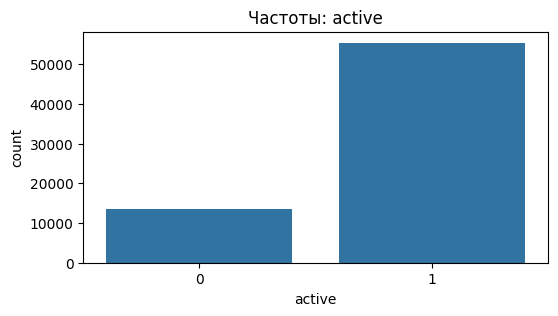

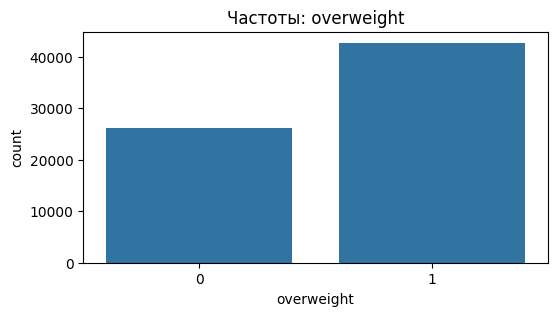

In [ ]:
#частоты категориальных переменных (визуальный контроль баланса уровней)
for col in ["gender","cholesterol","gluc","smoke","alco","active","overweight"]:
    if col in df.columns:
        plt.figure(figsize=(6,3))
        sns.countplot(x=df[col])
        plt.title(f"Частоты: {col}")
        plt.show()

In [ ]:
#Подготовка списков признаков и базового конвейера предобработки
#объявляем категориальные и числовые признаки под задачу
categorical_features = [c for c in ["gender","cholesterol","gluc","smoke","alco","active","overweight"] if c in df.columns]
numeric_features = [c for c in ["age_years","height","weight","ap_hi","ap_lo","bmi","pulse_pressure"] if c in df.columns]

#явная фиксация категориального типа — для корректной one-hot трансформации
for c in categorical_features:
    df[c] = df[c].astype("category")

#формируем матрицу признаков X и вектор целевой переменной y
feature_cols = categorical_features + numeric_features
X = df[feature_cols].copy()
y = df[TARGET_COL].astype(int).copy()

#стратифицированное разбиение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)

# - числовые признаки: медианное заполнение пропусков + стандартизация масштаба;
# - категориальные признаки: заполнение модой + one-hot кодирование (устойчивое к неизвестным уровням)
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ],
    remainder="drop" #неиспользуемые столбцы исключаются из конвейера
)

Выполнена первичная диагностика данных: пропусков не обнаружено; классы целевой переменной сбалансированы (≈50/50).

Реализован доменно-обоснованный feature engineering: добавлены age_years, bmi, pulse_pressure, бинарный индикатор overweight.

Проведена мягкая очистка экстремальных значений (квантильное клиппирование 1–99%) и удалены записи с некорректным соотношением артериального давления (ap_hi < ap_lo). После очистки размер набора составил 68 933 наблюдения (то есть удалено ~1.5% строк от исходных 70 000).

Выполнены базовые визуальные проверки (корреляции, распределения, частоты), подтверждающие разумность диапазонов признаков после клиппирования.

Сформированы списки признаков и унифицированный конвейер предобработки (ColumnTransformer) для последующего обучения моделей: числовые — медианное заполнение + стандартизация; категориальные — мода + one-hot.

Данные разделены на обучающую и тестовую выборки стратифицированно, что обеспечивает сопоставимость распределения классов.

# Этап 2. Финальный анализ, выбор модели и оформление результатов


Назначение: обучить несколько разнородных моделей бинарной классификации на едином конвейере предобработки, провести перекрёстную проверку (CV), сравнить метрики на тестовой выборке, выполнить тюнинг гиперпараметров лучшей модели и представить интерпретацию важности признаков.

In [ ]:
def eval_metrics(y_true, y_pred, y_proba):
    return {

        #Унифицированный расчёт ключевых метрик качества на тестовой выборке.
        # - accuracy, precision, recall, f1 — оценивают качество по различным аспектам ошибок;
        # - roc_auc — ранговая метрика, устойчива к выбору порога.

        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred, zero_division=0),
        "recall": recall_score(y_true, y_pred, zero_division=0),
        "f1": f1_score(y_true, y_pred, zero_division=0),
        "roc_auc": roc_auc_score(y_true, y_proba)
    }

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE) #5-складочная кросс-валидация
scoring = {"accuracy":"accuracy","precision":"precision","recall":"recall","f1":"f1","roc_auc":"roc_auc"} #набор метрик для сквозного сравнения на CV

CV (5-fold) — Logistic Regression


,mean,std
ACCURACY,0.7273,0.0028
PRECISION,0.7507,0.0040
RECALL,0.6720,0.0101
F1,0.7091,0.0048
ROC_AUC,0.7901,0.0037


Test — Logistic Regression
  ACCURACY : 0.7279
  PRECISION: 0.7492
  RECALL   : 0.6766
  F1       : 0.7110
  ROC_AUC  : 0.7942


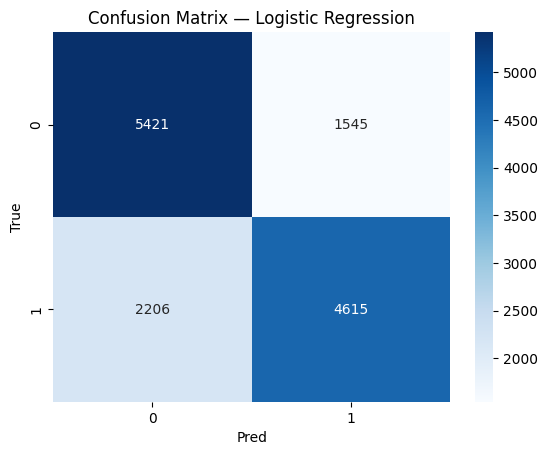

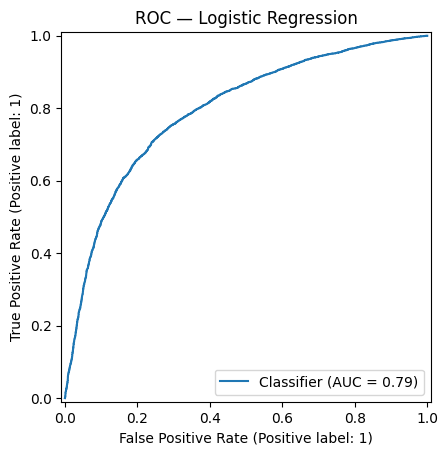

In [ ]:
# 1) Базовая модель (baseline) — Логистическая регрессия
logreg = LogisticRegression(max_iter=2000, class_weight="balanced", solver="liblinear", random_state=RANDOM_STATE)
logreg_clf = Pipeline([("preprocessor", preprocessor), ("model", logreg)])  # встраиваем предобработку в Pipeline во избежание утечки данных и для корректной CV

#перекрёстная проверка
cv_log = cross_validate(logreg_clf, X_train, y_train, cv=cv, scoring=scoring, n_jobs=-1)

#вывод результатов CV
cv_table = (pd.DataFrame(cv_log)
            .filter(regex=r"^test_")
            .rename(columns=lambda c: c.replace("test_", "").upper()))
cv_summary = pd.DataFrame({"mean": cv_table.mean(), "std": cv_table.std()})
print("CV (5-fold) — Logistic Regression")
display(cv_summary.applymap(lambda x: f"{x:.4f}"))

#финальное обучение на всём train и оценка на отложенном test
logreg_clf.fit(X_train, y_train)
pred_lr  = logreg_clf.predict(X_test)
proba_lr = logreg_clf.predict_proba(X_test)[:, 1]
metrics_lr = eval_metrics(y_test, pred_lr, proba_lr)

#вывод тестовых метрик
print("Test — Logistic Regression")
for k in ["accuracy", "precision", "recall", "f1", "roc_auc"]:
    print(f"  {k.upper():9s}: {metrics_lr[k]:.4f}")

#визуализация ошибок и ранжирования вероятностей
cm = confusion_matrix(y_test, pred_lr)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix — Logistic Regression"); plt.xlabel("Pred"); plt.ylabel("True"); plt.show()

RocCurveDisplay.from_predictions(y_test, proba_lr)
plt.title("ROC — Logistic Regression"); plt.show()


In [ ]:
# 2) Случайный лес (RandomForest)
#модель на деревьях решений; менее чувствительна к масштабу, даёт важности признаков
rf = RandomForestClassifier(
    n_estimators=400,
    class_weight="balanced_subsample",
    n_jobs=-1,
    random_state=RANDOM_STATE
)
rf_clf = Pipeline([("preprocessor", preprocessor), ("model", rf)])
cv_rf = cross_validate(rf_clf, X_train, y_train, cv=cv, scoring=scoring, n_jobs=-1)
print("CV mean (RF):", {k: np.mean(v) for k,v in cv_rf.items() if k.startswith("test_")})

CV mean (RF): {'test_accuracy': np.float64(0.7073767000326429), 'test_precision': np.float64(0.7077650668983071), 'test_recall': np.float64(0.6958426302250009), 'test_f1': np.float64(0.7017162893771618), 'test_roc_auc': np.float64(0.7688543859714378)}


In [ ]:
# 3) Градиентный бустинг XGBoost
#scale_pos_weight задаём от отношения негативов к позитивам на обучающей выборке (устойчивость к дисбалансу)
neg, pos = np.bincount(y_train)  # для scale_pos_weight
scale_pos_weight = neg / pos if pos > 0 else 1.0
xgb = XGBClassifier(
    n_estimators=600,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_lambda=1.0,
    objective="binary:logistic",
    eval_metric="auc",
    tree_method="hist", #быстрый и стабильный алгоритм построения деревьев
    scale_pos_weight=scale_pos_weight,
    random_state=RANDOM_STATE,
    n_jobs=-1
)
xgb_clf = Pipeline([("preprocessor", preprocessor), ("model", xgb)])
cv_xgb = cross_validate(xgb_clf, X_train, y_train, cv=cv, scoring=scoring, n_jobs=-1)
print("CV mean (XGB):", {k: np.mean(v) for k,v in cv_xgb.items() if k.startswith("test_")})

CV mean (XGB): {'test_accuracy': np.float64(0.7337611671923694), 'test_precision': np.float64(0.7497038601521374), 'test_recall': np.float64(0.6932770844517817), 'test_f1': np.float64(0.7203672080542854), 'test_roc_auc': np.float64(0.798729050924222)}


<Figure size 600x500 with 0 Axes>

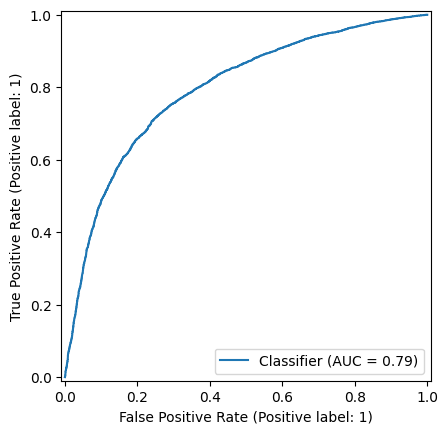

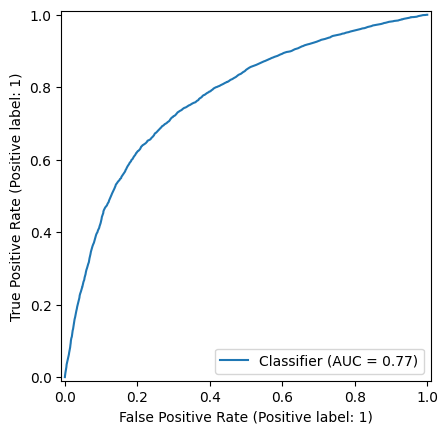

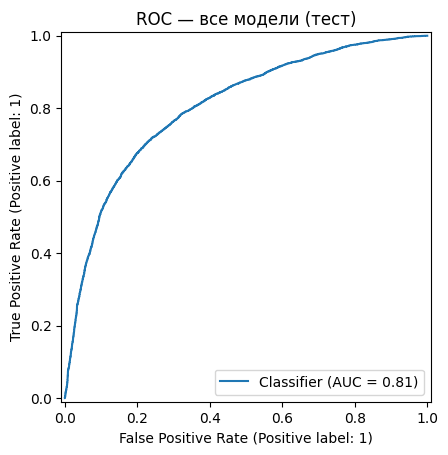

,accuracy,precision,recall,f1,roc_auc
model,,,,,
XGBoost,0.739247,0.752189,0.705322,0.728002,0.805378
LogReg,0.727932,0.749188,0.676587,0.711039,0.794204
RandomForest,0.709581,0.705831,0.708107,0.706967,0.771376


In [ ]:
#Сводное сравнение на тесте и общий график
#все модели обучаются на полном train (с одинаковой предобработкой), далее оцениваются на общем test
models = {"LogReg": logreg_clf, "RandomForest": rf_clf, "XGBoost": xgb_clf}
test_rows = []
plt.figure(figsize=(6,5))
for name, model in models.items():
    model.fit(X_train, y_train)
    p = model.predict(X_test)
    proba = model.predict_proba(X_test)[:,1]
    m = eval_metrics(y_test, p, proba); m["model"] = name; test_rows.append(m)
    RocCurveDisplay.from_predictions(y_test, proba)
plt.title("ROC — все модели (тест)"); plt.show()

#таблица метрик на отложенной выборке; сортировка по F1 как компромиссу между precision и recall
test_df = pd.DataFrame(test_rows).set_index("model").sort_values("f1", ascending=False)
display(test_df)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
Лучшие параметры: {'model__subsample': 0.85, 'model__reg_lambda': 1.0, 'model__n_estimators': 300, 'model__max_depth': 3, 'model__learning_rate': 0.1, 'model__colsample_bytree': 0.85}
Test (Best XGB): {'accuracy': 0.7364908972220208, 'precision': 0.74851886498285, 'recall': 0.7038557396276206, 'f1': 0.7255005666792596, 'roc_auc': np.float64(0.8050338265198551)}


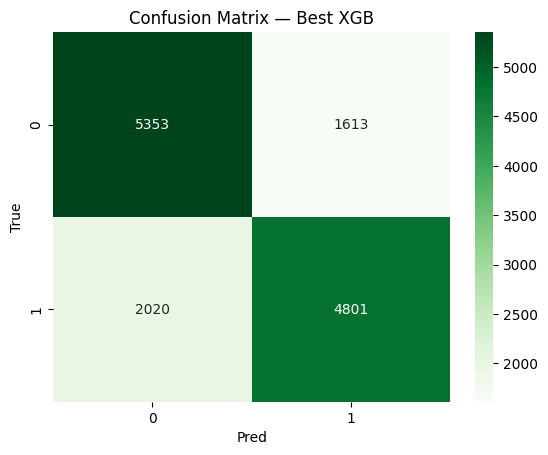

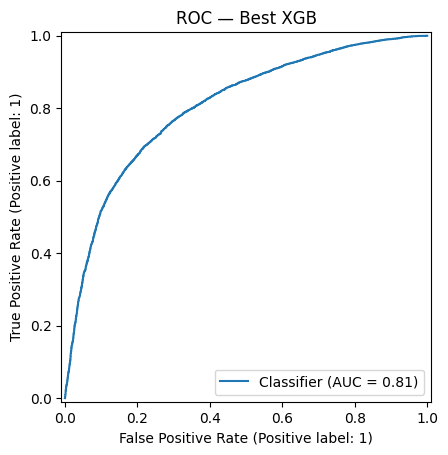

In [ ]:
#Цель: подобрать гиперпараметры XGBoost для повышения F1 на CV
#RandomizedSearchCV обеспечивает хороший компромисс между качеством и временем поиска
param_dist_xgb = {
    "model__n_estimators": [300, 500, 700, 900],
    "model__max_depth": [3, 4, 5, 6],
    "model__learning_rate": [0.02, 0.05, 0.1],
    "model__subsample": [0.7, 0.85, 1.0],
    "model__colsample_bytree": [0.7, 0.85, 1.0],
    "model__reg_lambda": [0.5, 1.0, 2.0, 5.0]
}
xgb_search = RandomizedSearchCV(
    estimator=xgb_clf, #включает предобработку внутри пайплайна
    param_distributions=param_dist_xgb,
    n_iter=25, #число испытаний в случайном поиске
    scoring="f1", #целевая метрика под задачу
    cv=cv,
    n_jobs=-1,
    random_state=RANDOM_STATE,
    verbose=1
)
xgb_search.fit(X_train, y_train)
print("Лучшие параметры:", xgb_search.best_params_)
best_xgb = xgb_search.best_estimator_

#оценка настроенной модели на отложенном тесте
pred_best = best_xgb.predict(X_test)
proba_best = best_xgb.predict_proba(X_test)[:,1]
metrics_best = eval_metrics(y_test, pred_best, proba_best)
print("Test (Best XGB):", metrics_best)

#визуализация ошибок и ROC для лучшей конфигурации XGB
cm = confusion_matrix(y_test, pred_best)
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens"); plt.title("Confusion Matrix — Best XGB"); plt.xlabel("Pred"); plt.ylabel("True"); plt.show()
RocCurveDisplay.from_predictions(y_test, proba_best); plt.title("ROC — Best XGB"); plt.show()

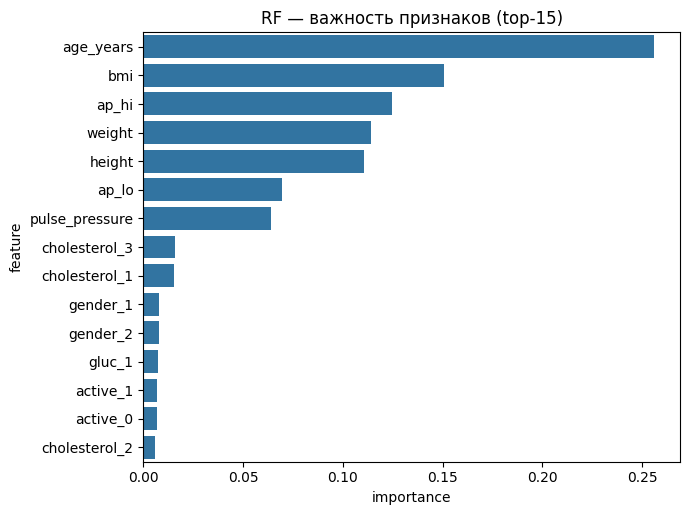

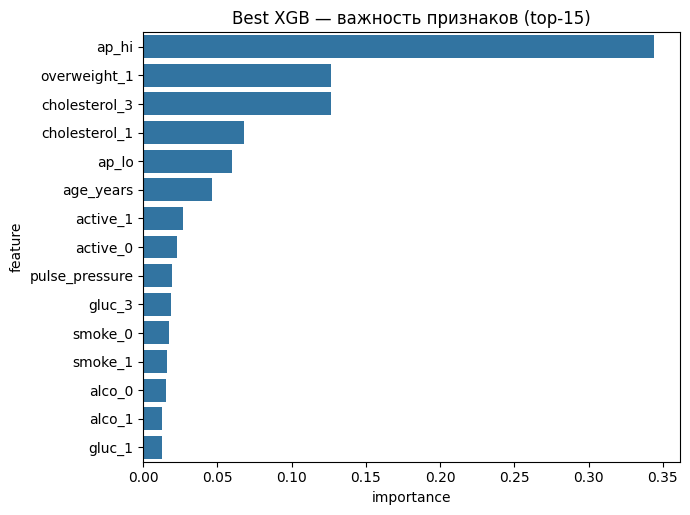

In [ ]:
#Интерпретация важностей
#извлечение имён признаков после ColumnTransformer (включая one-hot столбцы)
def get_feature_names_from_preprocessor(preprocessor):
    names = []
    for name, trans, cols in preprocessor.transformers_:
        if name == "num":
            names.extend(cols)
        elif name == "cat":
            ohe = trans.named_steps["onehot"]
            names.extend(ohe.get_feature_names_out(cols))
    return names

def plot_feature_importance(model_pipeline, top_n=15, title="Feature Importance"):

    #Отображение важности признаков:
    # - для деревьев/бустинга: feature_importances_;
    # - для логистической регрессии: абсолютные значения коэффициентов.

    model = model_pipeline.named_steps["model"]
    feat_names = get_feature_names_from_preprocessor(model_pipeline.named_steps["preprocessor"])
    if hasattr(model, "feature_importances_"):
        imp = model.feature_importances_
    elif hasattr(model, "coef_"):
        imp = np.abs(model.coef_.ravel())
    else:
        print("Модель не поддерживает важности/коэффициенты."); return
    imp_df = pd.DataFrame({"feature": feat_names, "importance": imp}).sort_values("importance", ascending=False).head(top_n)
    plt.figure(figsize=(7, max(4, top_n*0.35)))
    sns.barplot(data=imp_df, x="importance", y="feature")
    plt.title(title); plt.tight_layout(); plt.show()

#демонстрация интерпретации: важности для RF и для настроенного XGB
rf_fitted = rf_clf.fit(X_train, y_train)
plot_feature_importance(rf_fitted, title="RF — важность признаков (top-15)")
best_xgb_fitted = best_xgb.fit(X_train, y_train)
plot_feature_importance(best_xgb_fitted, title="Best XGB — важность признаков (top-15)")

In [ ]:
#Итоговая таблица
#свод метрик по ключевым финальным моделям (Logistic Regression, RF, tuned XGB) на тестовом наборе
summary_rows = []
def collect(name, model):
    p = model.predict(X_test)
    proba = model.predict_proba(X_test)[:,1]
    m = eval_metrics(y_test, p, proba); m["model"] = name; return m

summary_rows.append(collect("LogReg (baseline)", logreg_clf))
summary_rows.append(collect("RandomForest", rf_fitted))
summary_rows.append(collect("XGBoost (tuned)", best_xgb_fitted))
summary = pd.DataFrame(summary_rows).set_index("model").sort_values("f1", ascending=False)
display(summary)

print("\nКраткий вывод по лучшей модели:")
best_name = summary.index[0]
print(f"- Лучшая по F1: {best_name}")
print(f"- Метрики:\n{summary.loc[best_name].to_string()}")

,accuracy,precision,recall,f1,roc_auc
model,,,,,
XGBoost (tuned),0.736491,0.748519,0.703856,0.725501,0.805034
LogReg (baseline),0.727932,0.749188,0.676587,0.711039,0.794204
RandomForest,0.709581,0.705831,0.708107,0.706967,0.771376



Краткий вывод по лучшей модели:
- Лучшая по F1: XGBoost (tuned)
- Метрики:
accuracy     0.736491
precision    0.748519
recall       0.703856
f1           0.725501
roc_auc      0.805034


Проведено сопоставимое обучение трёх моделей (Logistic Regression, RandomForest, XGBoost) в едином конвейере предобработки; выполнена 5-складочная перекрёстная проверка.

Сформирована сводная оценка на отложенной выборке по метрикам Accuracy, Precision, Recall, F1, ROC-AUC; дополнительно построены матрицы ошибок и ROC-кривые.

Выполнен рандомизированный тюнинг гиперпараметров XGBoost по метрике F1; получена настроенная модель и её тестовые метрики.

Представлена интерпретация через важности признаков (деревья/бустинг) и абсолютные коэффициенты (для линейной модели).

Результаты сведены в итоговую таблицу, указан лидер по F1.

In [ ]:
from sklearn.base import clone
from sklearn.metrics import precision_recall_curve

# 1) Настройка порога на валидации (чтобы не «подглядывать» в тест)
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train, test_size=0.2, stratify=y_train, random_state=RANDOM_STATE
)
xgb_for_thr = clone(best_xgb)                 # берём ЛУЧШИЙ пайплайн из RandomizedSearchCV (необученный)
xgb_for_thr.fit(X_tr, y_tr)                   # обучаем только на train-части
proba_val = xgb_for_thr.predict_proba(X_val)[:, 1]

p, r, thr = precision_recall_curve(y_val, proba_val)
f1 = 2 * p * r / (p + r + 1e-9)
best_thr = thr[f1[:-1].argmax()]
print(f"Оптимальный порог по F1 (валидация): {best_thr:.3f}")

Оптимальный порог по F1 (валидация): 0.386


In [ ]:
# 2) Утилита: собрать корректную «однострочную» выборку c нужными фичами
def make_input_row(d: dict) -> pd.DataFrame:
    """
    Преобразует словарь в DataFrame с тем же набором/порядком признаков, что и при обучении.
    При отсутствии производных фич — рассчитывает их:
      - bmi = weight / (height/100)^2
      - pulse_pressure = ap_hi - ap_lo
      - overweight = int(bmi >= 25)
    Остальные отсутствующие поля заполняет NaN (импьютер в preprocessor обработает).
    """
    row = dict(d)  # копия
    # Производные признаки при необходимости
    if "bmi" not in row and {"height","weight"} <= row.keys():
        row["bmi"] = row["weight"] / ((row["height"] / 100.0) ** 2)
    if "pulse_pressure" not in row and {"ap_hi","ap_lo"} <= row.keys():
        row["pulse_pressure"] = row["ap_hi"] - row["ap_lo"]
    if "overweight" not in row and "bmi" in row:
        row["overweight"] = int(row["bmi"] >= 25)

    # Гарантируем наличие и порядок столбцов как в feature_cols
    full = {c: row.get(c, np.nan) for c in feature_cols}
    return pd.DataFrame([full], columns=feature_cols)

In [ ]:
my_input = {
    "gender": 2,          # 1 — женщина, 2 — мужчина
    "cholesterol": 2,     # 1 — норма, 2 — выше нормы, 3 — значительно выше
    "gluc": 1,
    "smoke": 1,
    "alco": 0,
    "active": 1,

    "age_years": 57.0,
    "height": 172.0,
    "weight": 86.0,
    "ap_hi": 150.0,
    "ap_lo": 95.0
}

row_df = make_input_row(my_input)

#4) Прогноз по лучшей обученной модели и интерпретация результата
proba = best_xgb_fitted.predict_proba(row_df)[0, 1]
pred  = int(proba >= best_thr)

print(f"\nВвод:")
display(row_df)

print(f"Вероятность риска (cardio=1): {proba:.3f}")
print("Вывод:", "ДА (есть риск)" if pred == 1 else "НЕТ (риск не выявлен)")


Ввод:


,gender,cholesterol,gluc,smoke,alco,active,overweight,age_years,height,weight,ap_hi,ap_lo,bmi,pulse_pressure
0,2,2,1,1,0,1,1,57.0,172.0,86.0,150.0,95.0,29.069767,55.0


Вероятность риска (cardio=1): 0.861
Вывод: ДА (есть риск)
